# Analysis of flight cancellations and delays data

### About the database

Dataset of flight cancellations and delays for US airlines in January 2023, extracted from the US Department of Transportation, Bureau of Transportation Statistics (https://www.transstats.bts.gov) and available on Kaggle.

Variables include flight routes (origin and destination), time intervals between events (minutes, time at destination), reasons/attributions for delays and cancellations.

#### Variable description

##### DOT_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Numeric identifier from the U.S. Department of Transportation (DOT) for airlines |
| Description | Airline description |

##### AIRLINE_CODE_DICTIONARY table

| Variable | Description |
| -------- | --------- |
| Code | Unique operator code for aircraft operator agencies |
| Description | Description of the aircraft operator agency |

##### flights_202301 table

| Variable | Description |
| -------- | --------- |
| FL_DATE | Flight date (yyyymmdd) |
| AIRLINE_CODE | Unique operator code. When multiple operators use the same code, a numeric suffix is used to differentiate previous users, e.g., PA, PA(1), PA(2). |
| DOT_CODE | Identification number assigned by the US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one that owns and reports under the same DOT certificate regardless of its code, name, or holding/company. |
| FL_NUMBER | Flight number |
| ORIGIN | Origin airport |
| ORIGIN_CITY | Origin airport, city name |
| DEST | Destination airport |
| DEST_CITY | Destination airport, city name |
| CRSDEPTIME | Scheduled departure time recorded in CRS (Computer Reservation System) (local time: hhmm) |
| DEP_TIME | Actual departure time (local time: hhmm) |
| DEP_DELAY | Difference in minutes between scheduled and actual departure time. Early departures show negative numbers. |
| TAXI_OUT | Taxi out time in minutes (taxi is the process of moving an airplane while it is on the runway) |
| WHEELS_OFF | Exact takeoff time (local time: hhmm) |
| WHEELS_ON | Exact landing time (local time: hhmm) |
| TAXI_IN | Taxi in time in minutes |
| CRSARRTIME | Scheduled arrival time recorded in CRS (local time: hhmm) |
| ARR_TIME | Actual arrival time (local time: hhmm) |
| ARR_DELAY | Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers. |
| CANCELLED | Flight cancelled indicator (1=Yes) |
| CANCELLATION_CODE | Specifies the reason for cancellation |
| DIVERTED | Flight diverted indicator (1=Yes) |
| CRSELAPSEDTIME | Total elapsed flight time in minutes recorded in CRS |
| ELAPSED_TIME | Total actual elapsed flight time in minutes |
| AIR_TIME | Air time in minutes |
| DISTANCE | Distance between airports (miles) |
| DELAYDUECARRIER | Carrier delay in minutes |
| DELAYDUEWEATHER | Weather delay in minutes |
| DELAYDUENAS | National Air System delay in minutes |
| DELAYDUESECURITY | Security delay in minutes |
| DELAYDUELATE_AIRCRAFT | Late aircraft delay in minutes |

## 1. Imports and data

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore


In [51]:
df_dot_code_dictionary = pd.read_excel("../dataset/DOT_CODE_DICTIONARY.xlsx")
df_airline_code_dictionary = pd.read_csv("../dataset/AIRLINE_CODE_DICTIONARY.csv")
df_flights_202301 = pd.read_csv("../dataset/flights_202301.csv")

## 2. Data treatment

### a. Renaming columns to create a pattern

In [52]:
df_dot_code_dictionary = df_dot_code_dictionary.rename(
    columns=lambda col: f"DOT_{col}" if col != "Code" else col
)
df_airline_code_dictionary = df_airline_code_dictionary.rename(
    columns=lambda col: f"AIRLINE_{col}" if col != "Code" else col
)

### b. Checking initial information and dimensions

In [53]:
print(f"Shape of df_flights_202301: {df_flights_202301.shape}")
print(f"Shape of df_dot_code_dictionary: {df_dot_code_dictionary.shape}")
print(f"Shape of df_airline_code_dictionary: {df_airline_code_dictionary.shape}")

Shape of df_flights_202301: (538837, 33)
Shape of df_dot_code_dictionary: (1737, 2)
Shape of df_airline_code_dictionary: (1729, 2)


In [54]:
df_flights_202301.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  538837 non-null  object 
 1   AIRLINE_CODE             538837 non-null  object 
 2   DOT_CODE                 538837 non-null  int64  
 3   FL_NUMBER                538837 non-null  int64  
 4   ORIGIN                   538837 non-null  object 
 5   ORIGIN_CITY              538837 non-null  object 
 6   DEST                     538837 non-null  object 
 7   DEST_CITY                538837 non-null  object 
 8   CRS_DEP_TIME             538837 non-null  int64  
 9   DEP_TIME                 528859 non-null  float64
 10  DEP_DELAY                528855 non-null  float64
 11  TAXI_OUT                 528640 non-null  float64
 12  WHEELS_OFF               528640 non-null  float64
 13  WHEELS_ON                528318 non-null  float64
 14  TAXI

In [55]:
df_airline_code_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Code                 1728 non-null   object
 1   AIRLINE_Description  1729 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB


In [56]:
df_dot_code_dictionary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int64 
 1   DOT_Description  1733 non-null   object
dtypes: int64(1), object(1)
memory usage: 27.3+ KB


### c. Optimizing data types for df_flights_202301

In [57]:
df_flights_optimized = df_flights_202301.copy()

In [58]:
# 1. DATE CONVERSION

df_flights_optimized["FL_DATE"] = pd.to_datetime(
    df_flights_optimized["FL_DATE"].astype(str),
    format="%Y-%m-%d",
    errors='coerce'
)

df_flights_optimized["FL_YEAR"] = df_flights_optimized["FL_DATE"].dt.year.astype('float32')
df_flights_optimized["FL_MONTH"] = df_flights_optimized["FL_DATE"] .dt.month.astype('float32')
df_flights_optimized["FL_DAY"] = df_flights_optimized["FL_DATE"] .dt.day.astype('float32')

In [59]:
# 2. CATEGORICAL COLUMNS

cols_category = [
    "AIRLINE_CODE", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CANCELLATION_CODE"
]
for col in cols_category:
    df_flights_optimized[col] = df_flights_optimized[col].astype("category")

In [60]:
# 3. BOOLEAN VARIABLES

df_flights_optimized["CANCELLED"] = df_flights_optimized["CANCELLED"].astype(bool)
df_flights_optimized["DIVERTED"] = df_flights_optimized["DIVERTED"].astype(bool)

In [61]:
# 4. FUNCTION FOR TIME CONVERSION
# Converter colunas de horários (HHMM) para int, ignorando erros

time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME", "AIR_TIME"]
for col in time_cols:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [62]:
# Converter atrasos e tempos para numérico
num_cols = ["TAXI_IN", "TAXI_OUT", "ELAPSED_TIME", "DEP_DELAY", "ARR_DELAY"]
for col in num_cols:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors="coerce")

In [63]:
# 5. NUMERIC TYPE OPTIMIZATION

# Columns that can be converted to smaller int (memory saving)
int_columns_small = ["FL_NUMBER", "DOT_CODE"]
for col in int_columns_small:
    if col in df_flights_optimized.columns:
        max_val = df_flights_optimized[col].max()
        if max_val <= 32767:  # int16
            df_flights_optimized[col] = df_flights_optimized[col].astype("int16")
        elif max_val <= 2147483647:  # int32
            df_flights_optimized[col] = df_flights_optimized[col].astype("int32")

# 'Distance' can likely be int16 (max ~32k miles)
if "DISTANCE" in df_flights_optimized.columns:
    df_flights_optimized["DISTANCE"] = df_flights_optimized["DISTANCE"].astype("int16")

# Convert to float32 (saves 50% memory vs float64)
float_columns = [
    "DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY",
    "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME",
    "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"
]
for col in float_columns:
    if col in df_flights_optimized.columns:
        df_flights_optimized[col] = pd.to_numeric(df_flights_optimized[col], errors='coerce')
        df_flights_optimized[col] = df_flights_optimized[col].astype("float32")

In [64]:
df_flights_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538837 entries, 0 to 538836
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FL_DATE                  538837 non-null  datetime64[ns]
 1   AIRLINE_CODE             538837 non-null  category      
 2   DOT_CODE                 538837 non-null  int16         
 3   FL_NUMBER                538837 non-null  int16         
 4   ORIGIN                   538837 non-null  category      
 5   ORIGIN_CITY              538837 non-null  category      
 6   DEST                     538837 non-null  category      
 7   DEST_CITY                538837 non-null  category      
 8   CRS_DEP_TIME             538837 non-null  int64         
 9   DEP_TIME                 528859 non-null  float64       
 10  DEP_DELAY                528855 non-null  float32       
 11  TAXI_OUT                 528640 non-null  float32       
 12  WHEELS_OFF      

### d. Optimizing data types for df_airline_code_dictionary

In [65]:
df_airline_optimized = df_airline_code_dictionary.copy()

In [66]:
# 1. Convert 'Code' to category
df_airline_optimized['Code'] = df_airline_optimized['Code'].astype('category')

# 2. Convert 'AIRLINE_Description' to category
df_airline_optimized['AIRLINE_Description'] = df_airline_optimized['AIRLINE_Description'].astype('category')

In [67]:
df_airline_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Code                 1728 non-null   category
 1   AIRLINE_Description  1729 non-null   category
dtypes: category(2)
memory usage: 163.0 KB


### e. Optimizing data types for df_dot_code_dictionary

In [68]:
df_dot_optimized = df_dot_code_dictionary.copy()

In [69]:
# 1. Convert to numeric type to ensure conversion works
df_dot_optimized['Code'] = pd.to_numeric(df_dot_optimized['Code'], errors='coerce')

# Check max value to choose best integer type
max_dot_code = df_dot_optimized['Code'].max()

if max_dot_code <= 32767:  # int16 limit
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int16')
elif max_dot_code <= 2147483647:  # int32 limit
    df_dot_optimized['Code'] = df_dot_optimized['Code'].astype('int32')

# 2. Convert 'DOT_Description' to category
df_dot_optimized['DOT_Description'] = df_dot_optimized['DOT_Description'].astype('category')

# 3. Remove the redundant part after ':'
df_dot_optimized["DOT_Description"] = df_dot_optimized["DOT_Description"].str.split(":").str[0].str.strip()

In [70]:
df_dot_optimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Code             1737 non-null   int16 
 1   DOT_Description  1733 non-null   object
dtypes: int16(1), object(1)
memory usage: 17.1+ KB


### f. Comparing optimized sizes

In [71]:
def compare_memory_usage(df_name, df_original, df_optimized):
    mem_original = df_original.memory_usage(deep=True).sum() / 1024**2
    mem_optimized = df_optimized.memory_usage(deep=True).sum() / 1024**2

    print(f"Memory improvement analysis for **{df_name}**")
    print(f"Original DataFrame: {mem_original:.2f} MB")
    print(f"Optimized DataFrame: {mem_optimized:.2f} MB")
    print(f"Savings: {mem_original - mem_optimized:.2f} MB ({((mem_original - mem_optimized) / mem_original * 100):.1f}%)")
    print("=" * 50)

compare_memory_usage("df_flights_202301", df_flights_202301, df_flights_optimized)
compare_memory_usage("df_airline_code_dictionary", df_airline_code_dictionary, df_airline_optimized)
compare_memory_usage("df_dot_code_dictionary", df_dot_code_dictionary, df_dot_optimized)

Memory improvement analysis for **df_flights_202301**
Original DataFrame: 306.27 MB
Optimized DataFrame: 68.97 MB
Savings: 237.31 MB (77.5%)
Memory improvement analysis for **df_airline_code_dictionary**
Original DataFrame: 0.20 MB
Optimized DataFrame: 0.33 MB
Savings: -0.13 MB (-66.2%)
Memory improvement analysis for **df_dot_code_dictionary**
Original DataFrame: 0.14 MB
Optimized DataFrame: 0.12 MB
Savings: 0.02 MB (13.3%)


### g. Merging data

Main: df_flights_202301

df_airline_code_dictionary: Code <> df_flights_202301: AIRLINE_CODE

df_dot_code_dictionary: Code <> df_flights_202301: DOT_CODE

In [72]:
df_merged = pd.merge(
    df_flights_optimized,
    df_dot_optimized,
    left_on="DOT_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

# Merge with AIRLINE_CODE
df = pd.merge(
    df_merged,
    df_airline_optimized,
    left_on="AIRLINE_CODE",
    right_on="Code",
    how="left"
).drop(columns=["Code"])

### h. Checking and treating nulls values

In [73]:
df.isnull().sum()

FL_DATE                         0
AIRLINE_CODE                    0
DOT_CODE                        0
FL_NUMBER                       0
ORIGIN                          0
ORIGIN_CITY                     0
DEST                            0
DEST_CITY                       0
CRS_DEP_TIME                    0
DEP_TIME                     9978
DEP_DELAY                    9982
TAXI_OUT                    10197
WHEELS_OFF                  10197
WHEELS_ON                   10519
TAXI_IN                     10519
CRS_ARR_TIME                    0
ARR_TIME                    10519
ARR_DELAY                   11640
CANCELLED                       0
CANCELLATION_CODE               0
DIVERTED                        0
CRS_ELAPSED_TIME                1
ELAPSED_TIME                11640
AIR_TIME                    11640
DISTANCE                        0
DELAY_DUE_CARRIER          422124
DELAY_DUE_WEATHER          422124
DELAY_DUE_NAS              422124
DELAY_DUE_SECURITY         422124
DELAY_DUE_LATE

In [74]:
def checkMissing(data,perc=0):
    missing = [(i, data[i].isna().mean()*100) for i in data]
    missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
    missing = missing[missing.percentage > perc]
    print(missing.sort_values("percentage", ascending=False).reset_index(drop=True))

print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
                column_name  percentage
0         DELAY_DUE_WEATHER   78.339832
1             DELAY_DUE_NAS   78.339832
2        DELAY_DUE_SECURITY   78.339832
3   DELAY_DUE_LATE_AIRCRAFT   78.339832
4         DELAY_DUE_CARRIER   78.339832
5                 ARR_DELAY    2.160208
6              ELAPSED_TIME    2.160208
7                  AIR_TIME    2.160208
8                   TAXI_IN    1.952167
9                 WHEELS_ON    1.952167
10                 ARR_TIME    1.952167
11                 TAXI_OUT    1.892409
12               WHEELS_OFF    1.892409
13                DEP_DELAY    1.852508
14                 DEP_TIME    1.851766
15         CRS_ELAPSED_TIME    0.000186


In [75]:
# Removing null in CRS_ELAPSED_TIME (1)
df = df.dropna(subset=["CRS_ELAPSED_TIME"])

In [76]:
# Checking null in CANCELLED and DIVERTED
null_columns = [
    "ARR_DELAY",
    "ELAPSED_TIME",
    "AIR_TIME",
    "TAXI_IN",
    "WHEELS_ON",
    "ARR_TIME",
    "TAXI_OUT",
    "WHEELS_OFF",
    "DEP_DELAY",
    "DEP_TIME",
    "CRS_ELAPSED_TIME"
]

df_null = df[df[null_columns].isna().any(axis=1)]

# Separar normal vs cancelado/desviado
null_flag_0 = df_null[(df_null["CANCELLED"] == 0) & (df_null["DIVERTED"] == 0)]
null_flag_1 = df_null[(df_null["CANCELLED"] == 1) | (df_null["DIVERTED"] == 1)]

total_rows = len(df)
prop_null_flag_0 = len(null_flag_0) / total_rows * 100
prop_null_flag_1 = len(null_flag_1) / total_rows * 100

print(f"Variáveis nulas em voo normal: {len(null_flag_0):,} ({prop_null_flag_0:.2f}%)")
print(f"Variáveis nulas em voo cancelado/desviado: {len(null_flag_1):,} ({prop_null_flag_1:.2f}%)")

dist = null_flag_1[["CANCELLED", "DIVERTED"]].value_counts()
dist_prop = dist / total_rows * 100

Variáveis nulas em voo normal: 0 (0.00%)
Variáveis nulas em voo cancelado/desviado: 11,639 (2.16%)


In [77]:
# Checkin about the DELAYS in CANCELLED and DIVERTED
delay_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

# Filtrar linhas com atraso nulo
df_null_delays = df[df[delay_cols].isna().any(axis=1)]

# Separar normal vs cancelado/desviado
delay_flag_0 = df_null_delays[(df_null_delays["CANCELLED"] == 0) & (df_null_delays["DIVERTED"] == 0)]
delay_flag_1 = df_null_delays[(df_null_delays["CANCELLED"] == 1) | (df_null_delays["DIVERTED"] == 1)]

total_rows = len(df)
prop_delay_flag_0 = len(delay_flag_0) / total_rows * 100
prop_delay_flag_1 = len(delay_flag_1) / total_rows * 100

print(f"\nTotal de dados: {total_rows:,}")
print(f"Delay nulo em voo normal: {len(delay_flag_0):,} ({prop_delay_flag_0:.2f}%)")
print(f"Delay nulo em voo cancelado/desviado: {len(delay_flag_1):,} ({prop_delay_flag_1:.2f}%)")

dist = delay_flag_1[["CANCELLED", "DIVERTED"]].value_counts()
dist_prop = dist / total_rows * 100

print("\nDistribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):")
print(pd.concat([dist, dist_prop.rename("proporção %")], axis=1))

# Linhas canceladas/desviadas onde TODOS os 5 delays estão nulos
all_delay_null = delay_flag_1[delay_flag_1[delay_cols].isna().all(axis=1)]

print(f"\nLinhas canceladas/desviadas com TODOS os 5 delays nulos: {len(all_delay_null):,}")
print(f"Proporção no total do banco: {len(all_delay_null) / total_rows * 100:.2f}%")


Total de dados: 538,836
Delay nulo em voo normal: 410,484 (76.18%)
Delay nulo em voo cancelado/desviado: 11,639 (2.16%)

Distribuição entre CANCELLED e DIVERTED (valores absolutos e % do total):
                    count  proporção %
CANCELLED DIVERTED                    
True      False     10294     1.910414
False     True       1345     0.249612

Linhas canceladas/desviadas com TODOS os 5 delays nulos: 11,639
Proporção no total do banco: 2.16%


In [78]:
df[delay_cols] = df[delay_cols].fillna(0)

In [79]:
print("Proportion of missing data in columns")
checkMissing(df)

Proportion of missing data in columns
    column_name  percentage
0      AIR_TIME    2.160026
1  ELAPSED_TIME    2.160026
2     ARR_DELAY    2.160026
3      ARR_TIME    1.951985
4     WHEELS_ON    1.951985
5       TAXI_IN    1.951985
6      TAXI_OUT    1.892227
7    WHEELS_OFF    1.892227
8     DEP_DELAY    1.852326
9      DEP_TIME    1.851584


### i. Checking duplicated values

In [80]:
df.duplicated().any()

np.False_

### j. Checking out-of-scope variable data 

In [81]:
# 1. Dates out-of-scope: 2023, january
print(df["FL_DATE"].min(), "→", df["FL_DATE"].max())

2023-01-01 00:00:00 → 2023-01-31 00:00:00


In [82]:
# 2. Checking expected ranges

check_ranges = {
    "FL_DAY": (1, 31),
    "DEP_TIME": (0, 2359),
    "ARR_TIME": (0, 2359),
    "CRS_DEP_TIME": (0, 2359),
    "CRS_ARR_TIME": (0, 2359),
    "TAXI_IN": (0, None),
    "TAXI_OUT": (0, None),
    "ELAPSED_TIME": (0, None),
    "AIR_TIME": (0, None),
    "DEP_DELAY": (None, None),
    "ARR_DELAY": (None, None),
}

for col, (low, high) in check_ranges.items():
    if col in df.columns:
        if low is not None:
            invalid_low = df[df[col] < low]
            if not invalid_low.empty:
                print(f"{col}: {len(invalid_low)} valores abaixo de {low}")
        if high is not None:
            invalid_high = df[df[col] > high]
            if not invalid_high.empty:
                print(f"{col}: {len(invalid_high)} valores acima de {high}")

DEP_TIME: 48 valores acima de 2359
ARR_TIME: 281 valores acima de 2359


In [83]:
invalid_dep_time_vals = df.loc[df["DEP_TIME"] > 2359, "DEP_TIME"].unique()
print("DEP_TIME inválidos únicos:", invalid_dep_time_vals)

invalid_arr_time_vals = df.loc[df["ARR_TIME"] > 2359, "ARR_TIME"].unique()
print("ARR_TIME inválidos únicos:", invalid_arr_time_vals)

DEP_TIME inválidos únicos: [2400.]
ARR_TIME inválidos únicos: [2400.]


In [84]:
time_cols = ["DEP_TIME", "ARR_TIME", "CRS_DEP_TIME", "CRS_ARR_TIME"]

for col in time_cols:
    if col in df.columns:
        df.loc[df[col] == 2400, col] = 0

### k. Checking the categorical data

In [85]:
# 1. List information about categorical data

categorical_data = df.select_dtypes(include=['object', 'category']).columns

print("🔎 Exploração de valores categóricos:\n")
print(categorical_data)

for data_column in categorical_data:
    print(f"📌 Coluna: {data_column}")
    print("Quantidade de categorias únicas:", df[data_column].nunique())
    print("Categorias encontradas:", df[data_column].unique())
    print("-" * 80)

🔎 Exploração de valores categóricos:

Index(['AIRLINE_CODE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CANCELLATION_CODE', 'DOT_Description', 'AIRLINE_Description'],
      dtype='object')
📌 Coluna: AIRLINE_CODE
Quantidade de categorias únicas: 15
Categorias encontradas: ['9E' 'AA' 'AS' 'B6' 'DL' 'F9' 'G4' 'HA' 'MQ' 'NK' 'WN' 'YX' 'OH' 'OO'
 'UA']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN
Quantidade de categorias únicas: 339
Categorias encontradas: ['BDL', 'LGA', 'DLH', 'ATL', 'FAY', ..., 'APN', 'PLN', 'BJI', 'GUM', 'SPN']
Length: 339
Categories (339, object): ['ABE', 'ABI', 'ABQ', 'ABR', ..., 'XNA', 'XWA', 'YAK', 'YUM']
--------------------------------------------------------------------------------
📌 Coluna: ORIGIN_CITY
Quantidade de categorias únicas: 333
Categorias encontradas: ['Hartford, CT', 'New York, NY', 'Duluth, MN', 'Atlanta, GA', 'Fayetteville, NC', ..., 'Alpena, MI', 'Pellston, MI', 'Bemidji, MN', 'Guam, T

In [86]:
# 2. Create pattern
    
df[categorical_data] = df[categorical_data].apply(
    lambda col: col.astype(str)
                    .str.strip()
                    .str.upper()
                    .replace(['NA', 'N/A', 'NONE', 'NULL', '?', 'UNKNOWN'], np.nan)
)

if 'DOT_Description' in df.columns:
    df['DOT_Description'] = df['DOT_Description'].str.strip()

In [87]:
# 3. Checking similarity in DOT_Description and AIRLINE_Description

count_DOT_Description = df['DOT_Description'].value_counts()
print(count_DOT_Description)

count_AIRLINE_Description = df['AIRLINE_Description'].value_counts()
print(f"\n{count_AIRLINE_Description}")

DOT_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR               8615
HAWAIIAN AIRLINES INC.      6697
Name: count, dtype: int64

AIRLINE_Description
SOUTHWEST AIRLINES CO.    112430
DELTA AIR LINES INC.       75174
AMERICAN AIRLINES INC.     74999
UNITED AIR LINES INC.      56657
SKYWEST AIRLINES INC.      50346
REPUBLIC AIRLINE           24476
JETBLUE AIRWAYS            23249
SPIRIT AIR LINES           21876
ALASKA AIRLINES INC.       19801
ENVOY AIR                  18849
ENDEAVOR AIR INC.          16926
PSA AIRLINES INC.          15456
FRONTIER AIRLINES INC.     13285
ALLEGIANT AIR

In [88]:
# Lines are the same?
similar_description = (df['DOT_Description'] == df['AIRLINE_Description']).all()
print("As colunas são idênticas linha a linha?", similar_description)

if not similar_description:
    dif = df[df['DOT_Description'] != df['AIRLINE_Description']]
    print(f"Número de diferenças: {len(dif)}")
    print(dif.head())

#  Same unique values?
similar_category = set(df['DOT_Description'].dropna().unique()) == set(df['AIRLINE_Description'].dropna().unique())
print("As colunas têm os mesmos valores únicos?", similar_category)

As colunas são idênticas linha a linha? True
As colunas têm os mesmos valores únicos? True


In [89]:
# Removing DOT_DESCRIPTION
df = df.drop('DOT_Description', axis=1)

In [90]:
# 4. Checking inconsistent values
categorical_data = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_data:
    print(f"{col}: {df[col].isin(['NA','?','None','UNKNOWN']).sum()} valores suspeitos")

AIRLINE_CODE: 0 valores suspeitos
ORIGIN: 0 valores suspeitos
ORIGIN_CITY: 0 valores suspeitos
DEST: 0 valores suspeitos
DEST_CITY: 0 valores suspeitos
CANCELLATION_CODE: 0 valores suspeitos
AIRLINE_Description: 0 valores suspeitos


### l. Checking the numerical data

In [ ]:
numeric_cols = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_IN', 'TAXI_OUT',
    'AIR_TIME', 'ELAPSED_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

def detect_outliers_iqr(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

def detect_outliers_zscore(series, threshold=3):
    z_scores = zscore(series.dropna())
    return series.iloc[(abs(z_scores) > threshold).nonzero()[0]]

outliers_iqr, outliers_zscore = {}, {}

for col in numeric_cols:
    if col in df_merged.columns:
        outliers_iqr[col] = detect_outliers_iqr(df_merged[col])
        outliers_zscore[col] = detect_outliers_zscore(df_merged[col])

print("🔎 Outliers identificados (IQR):")
for col, vals in outliers_iqr.items():
    print(f"- {col}: {len(vals)} registros")

print("\n🔎 Outliers identificados (Z-Score):")
for col, vals in outliers_zscore.items():
    print(f"- {col}: {len(vals)} registros")


🔎 Outliers identificados (IQR):
- DEP_DELAY: 65189 registros
- ARR_DELAY: 48102 registros
- TAXI_IN: 36666 registros
- TAXI_OUT: 35661 registros
- AIR_TIME: 26674 registros
- ELAPSED_TIME: 25005 registros
- CRS_ELAPSED_TIME: 27542 registros
- DISTANCE: 32099 registros
- DELAY_DUE_CARRIER: 12005 registros
- DELAY_DUE_WEATHER: 6507 registros
- DELAY_DUE_NAS: 8966 registros
- DELAY_DUE_SECURITY: 626 registros
- DELAY_DUE_LATE_AIRCRAFT: 12750 registros

🔎 Outliers identificados (Z-Score):
- DEP_DELAY: 7656 registros
- ARR_DELAY: 7475 registros
- TAXI_IN: 10083 registros
- TAXI_OUT: 9732 registros
- AIR_TIME: 8061 registros
- ELAPSED_TIME: 7721 registros
- CRS_ELAPSED_TIME: 8720 registros
- DISTANCE: 4831 registros
- DELAY_DUE_CARRIER: 1395 registros
- DELAY_DUE_WEATHER: 1045 registros
- DELAY_DUE_NAS: 2270 registros
- DELAY_DUE_SECURITY: 495 registros
- DELAY_DUE_LATE_AIRCRAFT: 1936 registros


## 3. Exploratory Data Analysis (EDA)

### a. Merge and see categorial information

In [ ]:
# Contagem de voos cancelados e desviados
print("Voos Cancelados:")
print(df["CANCELLED"] .sum())
print("Voos Desviados:")
print(df["DIVERTED"] .sum())

Voos Cancelados:
10294
Voos Desviados:
1345


In [94]:
# Top 10 companhias aéreas com mais atrasos (considerando DEP_DELAY > 0)
top_delayed_airlines = df[df["DEP_DELAY"] > 0].groupby("AIRLINE_Description")["DEP_DELAY"] .count().nlargest(10)
print("Top 10 Companhias Aéreas com Mais Atrasos na Partida:")
print(top_delayed_airlines)

Top 10 Companhias Aéreas com Mais Atrasos na Partida:
AIRLINE_Description
SOUTHWEST AIRLINES CO.    51880
DELTA AIR LINES INC.      28270
AMERICAN AIRLINES INC.    26095
UNITED AIR LINES INC.     23266
SKYWEST AIRLINES INC.     15423
SPIRIT AIR LINES           9594
JETBLUE AIRWAYS            9354
ALASKA AIRLINES INC.       6957
FRONTIER AIRLINES INC.     6717
ENVOY AIR                  5856
Name: DEP_DELAY, dtype: int64


In [95]:
# Média de atraso por companhia aérea
avg_delay_airline = df.groupby("AIRLINE_Description")["DEP_DELAY"] .mean().sort_values(ascending=False)
print("Média de Atraso na Partida por Companhia Aérea:")
print(avg_delay_airline.head())

Média de Atraso na Partida por Companhia Aérea:
AIRLINE_Description
FRONTIER AIRLINES INC.    26.052259
SPIRIT AIR LINES          18.594975
ALLEGIANT AIR             17.502411
JETBLUE AIRWAYS           16.881086
AMERICAN AIRLINES INC.    14.610332
Name: DEP_DELAY, dtype: float32


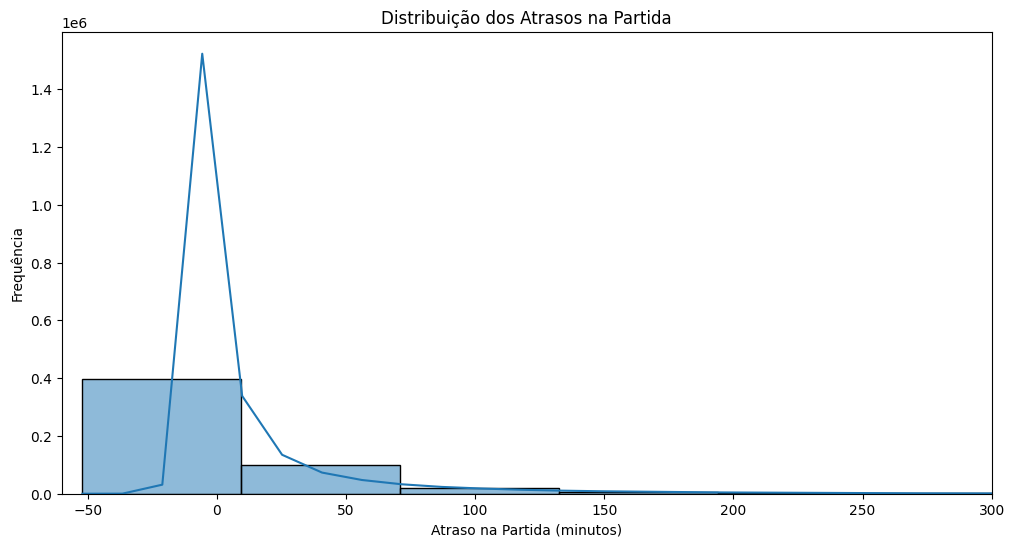

In [96]:
# Distribuição dos atrasos

plt.figure(figsize=(12, 6))
sns.histplot(df["DEP_DELAY"] .dropna(), bins=50, kde=True)
plt.title("Distribuição dos Atrasos na Partida")
plt.xlabel("Atraso na Partida (minutos)")
plt.ylabel("Frequência")
plt.xlim(-60, 300) # Limitar o eixo x para melhor visualização de atrasos comuns
plt.show()

In [97]:
# Atrasos por dia da semana (se FL_DATE foi convertida corretamente, podemos extrair o dia da semana)
df["DAY_OF_WEEK"] = df["FL_DATE"] .dt.day_name()
delay_by_day = df.groupby("DAY_OF_WEEK")["DEP_DELAY"] .mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
print("Média de Atraso na Partida por Dia da Semana:")
print(delay_by_day)

Média de Atraso na Partida por Dia da Semana:
DAY_OF_WEEK
Monday       14.987736
Tuesday      12.078774
Wednesday    26.550163
Thursday     10.890819
Friday        7.716964
Saturday      6.407958
Sunday       11.926554
Name: DEP_DELAY, dtype: float32


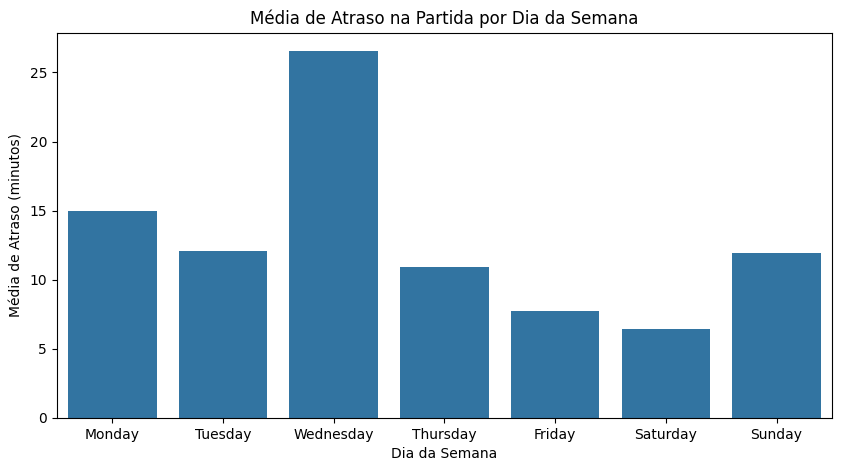

In [98]:
plt.figure(figsize=(10, 5))
sns.barplot(x=delay_by_day.index, y=delay_by_day.values)
plt.title("Média de Atraso na Partida por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Média de Atraso (minutos)")
plt.show()